In [1]:
# 전체 코드 예시: Pandas DataFrame에 저장된 데이터를 사용하여 GAN을 학습시키는 예제
"""
코드 : https://github.com/u7javed/Conditional-WGAN-GP/blob/master/train.py
"""
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 500)
pd.set_option('display.max_rows', 50)
import time

import os
import random
import warnings
warnings.filterwarnings(action='ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# 동일 결과 재생성을 위한 랜덤성 고정
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device = torch.device("cpu")
print('Using device:', device)

Using device: cpu


### 전체 원재료코드(JRCODE) 및 공정종류(PUTGB) 인코딩 테이블 및 nast 딕셔너리 생성

In [3]:
combined_df = pd.read_csv(f'./final_dataset/combined_pps_data_fin.csv')

In [4]:
tmp_df = combined_df.copy()
tmp_df = tmp_df.fillna(np.nan)

# 원재료 코드 리스트 생성
JRCODE_ls = []
jrcode_col_ls = [col for col in tmp_df.columns if 'JRCODE' in col]
for jrcode_col in jrcode_col_ls:
    JRCODE_ls += tmp_df[jrcode_col].unique().tolist()
    JRCODE_ls = list(set(JRCODE_ls))
    JRCODE_ls = [x for x in JRCODE_ls if str(x) != 'nan']

# 이상 원재료코드 리스트 생성
rm_jrcode_ls = [jr for jr in JRCODE_ls if 'C1' in jr]

for rm_jr in rm_jrcode_ls:
    JRCODE_ls.remove(rm_jr)

# 원재료 코드 테이블 생성
JRCODE_df = pd.DataFrame({'JRCODE':JRCODE_ls}).sort_values('JRCODE').reset_index(drop=True)
JRCODE_df['JR_ID'] = JRCODE_df.index
JRCODE_df = JRCODE_df[['JRCODE','JR_ID']]

# 공정 타입 테이블 생성 (1-6)
PUTGB_df = pd.DataFrame({'PUTGB':['P','CH','CB','OA','OB','F']}).reset_index(drop=True)
PUTGB_df['PUTGB_ID'] = PUTGB_df.index + 1 # (1-6)
PUTGB_df.columns = ['PUTGB_ID','PUTGB']

display(f'전체 원재료코드 수 : {len(JRCODE_df)}, 공정종류 수 : {len(PUTGB_df)}')

# 원재료 코드 dictionary 생성
JRCODE_dict = {}
for idx, row in JRCODE_df.iterrows():
    JRCODE_dict[row['JRCODE']] = row['JR_ID']

# 공정 타입 dictionary 생성
PUTGB_dict = {}
for idx, row in PUTGB_df.iterrows():
    PUTGB_dict[row['PUTGB']] = row['PUTGB_ID']

# nan을 마지막으로 추가
JRCODE_dict['0'] = len(JRCODE_dict)+1
PUTGB_dict['0'] = len(PUTGB_dict)+1

display(f'NAN포함!! JRCODE 딕셔너리 길이: {len(JRCODE_dict)}, PUTGB 딕셔너리 길이: {len(PUTGB_dict)}')

'전체 원재료코드 수 : 833, 공정종류 수 : 6'

'NAN포함!! JRCODE 딕셔너리 길이: 834, PUTGB 딕셔너리 길이: 7'

In [5]:
filtered_idx_ls = []
for rm_jrcode in rm_jrcode_ls:
    for col in jrcode_col_ls:
        tmp_tmp_df = tmp_df[~(tmp_df[col].isna())]
        filtered_idx_ls += tmp_tmp_df[(tmp_tmp_df[col].str.contains(rm_jrcode))].index.tolist()

        filtered_idx_ls = list(set(filtered_idx_ls))

tmp_df = tmp_df.iloc[[idx for idx in tmp_df.index if idx not in filtered_idx_ls]].reset_index(drop=True)
tmp_df = tmp_df.fillna(0)
tmp_df

,ID,TYPE,RPM1,RPM2,RPM3,RPM4,RPM5,RPM6,RPM7,RPM8,RPM9,RPM10,RPM11,RPM12,RPM13,RPM14,RPM15,RPM16,RPM17,RPM18,RPM19,RPM20,RPM21,RPM22,RPM23,TEMP1,TEMP2,TEMP3,TEMP4,TEMP5,TEMP6,TEMP7,TEMP8,TEMP9,TEMP10,TEMP11,TEMP12,TEMP13,TEMP14,TEMP15,TEMP16,TEMP17,TEMP18,TEMP19,TEMP20,TEMP21,TEMP22,TEMP23,TIME1,TIME2,TIME3,TIME4,TIME5,TIME6,TIME7,TIME8,TIME9,TIME10,TIME11,TIME12,TIME13,TIME14,TIME15,TIME16,TIME17,TIME18,TIME19,TIME20,TIME21,TIME22,TIME23,JUK1,JUK2,JUK3,JUK4,JUK5,JUK6,JUK7,JUK8,JUK9,JUK10,JUK11,JUK12,JUK13,JUK14,JUK15,JUK16,JUK17,JUK18,JUK19,JUK20,JUK21,JUK22,JUK23,JRCODE1,JRCODE2,JRCODE3,JRCODE4,JRCODE5,JRCODE6,JRCODE7,JRCODE8,JRCODE9,JRCODE10,JRCODE11,JRCODE12,JRCODE13,JRCODE14,JRCODE15,JRCODE16,JRCODE17,JRCODE18,JRCODE19,JRCODE20,JRCODE21,JRCODE22,JRCODE23,JRCODE24,JRCODE25,PHR1,PHR2,PHR3,PHR4,PHR5,PHR6,PHR7,PHR8,PHR9,PHR10,PHR11,PHR12,PHR13,PHR14,PHR15,PHR16,PHR17,PHR18,PHR19,PHR20,PHR21,PHR22,PHR23,PHR24,PHR25,PUTGB1,PUTGB2,PUTGB3,PUTGB4,PUTGB5,PUTGB6,PUTGB7,PUTGB8,PUTGB9,PUTGB10,PUTGB11,PUTGB12,PUTGB13,PUTGB14,PUTGB15,PUTGB16,PUTGB17,PUTGB18,PUTGB19,PUTGB20,PUTGB21,PUTGB22,PUTGB23,PUTGB24,PUTGB25,HS_TEMP,HS_TIME,SG_TEMP,SG_TIME,TS_TEMP,TS_TIME,EB_TEMP,EB_TIME,HS_VAL,SG_VAL,TS_VAL,EB_VAL
0,0000QY001_T010,LAB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,EE017A,EE011G,EE023A,CB003A,CB001C,CB011B,CD023B,CD013A,CD011A,CD005A,FF005A,NN031A,OP004A,OP005A,0,0,0,0,0,0,0,0,0,0,0,9.523810,27.619048,41.428571,2.380952,0.47619,0.47619,0.47619,0.714286,0.714286,0.714286,100.000,54.285714,38.095238,19.047619,0.000,0.000,0.000,0.000000,0.000,0.000000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,170.0,10.0,170.0,10.0,170.0,10.0,170.0,10.0,74.0,1.100,151.0,245.0
1,0504PA001_T001,LAB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,EZ008A,CV005B,CW007A,CD005A,NN045A,NN774A,OA001C,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000,0.000,0.000,0.000000,0.000,0.000000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,170.0,10.0,170.0,10.0,170.0,10.0,170.0,10.0,54.0,1.263,200.0,594.0
2,0504PA001_T002,LAB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,EZ008A,CV005B,CW007A,CD005A,NN045A,NN774A,OA001C,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,100.000000,10.000000,1.000000,2.000000,10.00000,15.00000,15.00000,0.000000,0.000000,0.000000,

In [14]:
# Discriminator 모델 정의
class Discriminator(nn.Module):
    def __init__(self, input_size, condition_size):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size + condition_size, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(64, 16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(16, 1),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        return self.model(x)

# Generator 모델 정의
class Generator(nn.Module):
    def __init__(self, input_size, output_size, condition_size):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size + condition_size, 128),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.BatchNorm1d(64),
            nn.Linear(128, 32),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.BatchNorm1d(64),
            nn.Linear(32, 128),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.BatchNorm1d(64),
            nn.Linear(128, output_size),
        )
    
    def forward(self, x):
        return self.model(x)
    
# For checking CGAN's validity in final step
def check_condition(_generator, sample_num, target_labels, condition_size_ls, latent_size):
    for i in np.arange(len(target_labels)):
        test_label = torch.full((1, sample_num), target_labels[i]).squeeze(0)    
        if i == 0:            
            test_label_encoded = F.one_hot(test_label, num_classes=condition_size_ls[i]).to(device)
        else:
            test_label_encoded = torch.cat((test_label_encoded, F.one_hot(test_label, num_classes=condition_size_ls[i]).to(device)), 1)

    # create noise(latent vector) 'z'
    _z = torch.randn(sample_num, latent_size).to(device)
    _z_concat = torch.cat((_z, test_label_encoded), 1)
    generated_data = _generator(_z_concat)

    return generated_data.detach()

def gradient_penalty(discriminator, real_samples, fake_samples, label_encoded):
        # Random weight term for interpolation between real and fake samples
        # alpha = tf.random.normal([real.shape[0], 1], 0.0, 1.0)
        alpha = torch.Tensor(np.random.random((real_samples.size(0), 1)))#.to(device)
        # Get random interpolation between real and fake samples
        interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
        d_interpolates = discriminator(torch.cat((interpolates, label_encoded), 1))
        fake = torch.Tensor(real_samples.shape[0], 1).fill_(1.0)#.to(device)
        fake.requires_grad = False
        # Get gradient w.r.t. interpolates
        gradients = torch.autograd.grad(
            outputs=d_interpolates,
            inputs=interpolates,
            grad_outputs=fake,
            create_graph=True,
            retain_graph=True,
            only_inputs=True,
        )
        gradients = gradients[0].view(gradients[0].size(0), -1)
        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
        return gradient_penalty

In [24]:
batch_size = 64
lr = 0.00005
num_epochs = 100
show_step = 10
latent_size_ = 100

stVal = 0
gp_weight = 5

criterion = nn.BCELoss()

# 대상
trg_yCols = ['HS_VAL','SG_VAL','TS_VAL','EB_VAL']

data_df = tmp_df.copy()
for i in range(1, 26):
    data_df['JRCODE'+str(i)] = data_df['JRCODE'+str(i)].apply(lambda x: int(JRCODE_dict[str(x)]))
    data_df['PHR'+str(i)].fillna(0, inplace=True)

grNum_ls = []

for yCol in trg_yCols:
    nUniq = data_df[yCol].nunique()
    if nUniq < 100:
        grNum = nUniq//5
    else:
        grNum = min(50, nUniq//10)
    
    # print(f'groupNum : {grNum}')
    data_df[yCol+'_G'], cutBins = pd.qcut(data_df[yCol],grNum, labels=np.arange(stVal,stVal+grNum), retbins=True)
    grNum_ls.append(grNum)

# 필요없는 변수 제거
data_df = data_df.drop(['ID','TYPE'] + trg_yCols, axis=1)

# batch_size 로 나눠지도록 나머지 버림
data_df = data_df.iloc[:-(len(data_df) % batch_size)]

# DataFrame을 PyTorch Tensor로 변환
data = torch.tensor(data_df.values, dtype=torch.float32)

# DataLoader 설정
dataset = TensorDataset(data)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 모델, 옵티마이저, 손실 함수 설정
condition_size = sum(grNum_ls)                              # 조건 feature의 개수
input_size = len(data_df.columns) - len(trg_yCols)          # 입력 feature의 개수
output_size = input_size                                    # 출력 feature의 개수 (입력과 동일하게)
latent_size = latent_size_                                  # 잠재 공간의 크기

discriminator = Discriminator(input_size, condition_size)
generator = Generator(latent_size, output_size, condition_size)
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr)
g_optimizer = optim.Adam(generator.parameters(), lr=lr)

p_d_real_trace = []
p_d_gen_trace = []
p_g_gen_trace = []

# 학습 시작
stTime = time.time()

gen_loss_trace = []
dis_loss_trace = []
was_loss_trace = []

for epoch in range(num_epochs):

    gen_loss = 0
    dis_loss = 0

    for n, (real_data,) in enumerate(dataloader):
        # batch_size = real_samples.size(0)

        real_data_labels = torch.ones((batch_size, 1))
        fake_data_labels = torch.zeros((batch_size, 1))

        x = real_data[:,:-len(trg_yCols)]
        labels = real_data[:,-len(trg_yCols):]

        """
        FOR CONDITIONAL GAN
        """
        for i in np.arange(len(trg_yCols)):
            # Encode label with 'one hot encoding'
            if i == 0:
                label_encoded = F.one_hot(labels[:,i].to(torch.int64), num_classes=grNum_ls[i]).squeeze(1)
            else:
                label_encoded = torch.cat((label_encoded, F.one_hot(labels[:,i].to(torch.int64), num_classes=grNum_ls[i]).squeeze(1)), 1)

        # concat real images with 'label encoded vector'
        real_data_concat = torch.cat((x, label_encoded), 1)

        # # Encode MNIST's label's with 'one hot encoding'
        # label_encoded = F.one_hot(labels.to(torch.int64), num_classes=condition_size).squeeze(1)
        # # concat real images with 'label encoded vector'
        # real_data_concat = torch.cat((real_data, label_encoded), 1)

        # +---------------------+
        # | train Discriminator |
        # +---------------------+

        # Initialize grad
        d_optimizer.zero_grad()

        # make fake images with generator & noise vector 'z'
        z = torch.randn(batch_size, latent_size)

        """
        FOR CONDITIONAL GAN
        """
        # concat noise vector z with encoded labels
        z_concat = torch.cat((z, label_encoded), 1)
        fake_data = generator(z_concat)
        fake_data_concat = torch.cat((fake_data, label_encoded), 1)

        # Calculate fake & real loss with generated images above & real images
        d_loss_fake = torch.mean(discriminator(fake_data_concat))
        d_loss_real = torch.mean(discriminator(real_data_concat))

        gp = gradient_penalty(discriminator, x, fake_data, label_encoded)

        d_loss = d_loss_fake - d_loss_real
        was_loss = (d_loss_fake + d_loss_real) + gp_weight*gp
        was_loss.backward()
        d_optimizer.step()

        dis_loss += d_loss.item()/batch_size

        d_performance = discriminator(real_data_concat).mean()
        g_performance = discriminator(fake_data_concat).mean()

        # +---------------------+
        # |   train Generator   |
        # +---------------------+

        # Initialize grad
        g_optimizer.zero_grad()

        # make fake data with generator & noise vector 'z'
        z = torch.randn(batch_size, latent_size)

        """
        FOR CONDITIONAL GAN
        """
        # concat noise vector z with encoded labels
        z_concat = torch.cat((z, label_encoded), 1)
        fake_data = generator(z_concat)
        fake_data_concat = torch.cat((fake_data, label_encoded), 1)

        # Compare result of discriminator with fake images & real labels
        # If generator deceives discriminator, g_loss will decrease
        g_loss = -torch.mean(discriminator(fake_data_concat))

        # Train generator with backpropagation
        g_loss.backward()
        g_optimizer.step()

        gen_loss += g_loss.item()/batch_size

        p_d_real_trace.append(d_loss_real.item())
        p_d_gen_trace.append(d_loss_fake.item())
        p_g_gen_trace.append(-g_loss.item())

    # Show loss
    if epoch % show_step == 0:
        print(f"Epoch: {epoch:3.0f} Loss D.: {dis_loss:.5f}, Loss G.: {gen_loss:.5f}, Loss W.: {was_loss:.5f}, time: {(time.time() - stTime):.3f}s")
        stTime = time.time()

    gen_loss_trace.append(gen_loss)
    dis_loss_trace.append(dis_loss)
    was_loss_trace.append(was_loss.item())

Epoch:   0 Loss D.: 3.73753, Loss G.: -3.96064, Loss W.: 5.48654, time: 6.886s
Epoch:  10 Loss D.: -0.02733, Loss G.: -0.22062, Loss W.: 4.93840, time: 58.353s
Epoch:  20 Loss D.: -0.00493, Loss G.: -0.20004, Loss W.: 4.93739, time: 58.073s
Epoch:  30 Loss D.: -0.01741, Loss G.: -0.02306, Loss W.: 4.99642, time: 58.856s
Epoch:  40 Loss D.: -0.00807, Loss G.: -0.00229, Loss W.: 4.96964, time: 53.790s
Epoch:  50 Loss D.: -0.00208, Loss G.: -0.01817, Loss W.: 4.94906, time: 53.647s
Epoch:  60 Loss D.: 0.03433, Loss G.: -0.05485, Loss W.: 4.96844, time: 53.984s
Epoch:  70 Loss D.: 0.06344, Loss G.: -0.06977, Loss W.: 5.00983, time: 53.972s
Epoch:  80 Loss D.: 0.00920, Loss G.: -0.02410, Loss W.: 4.96481, time: 55.580s
Epoch:  90 Loss D.: 0.00000, Loss G.: -0.00000, Loss W.: 5.00000, time: 53.467s


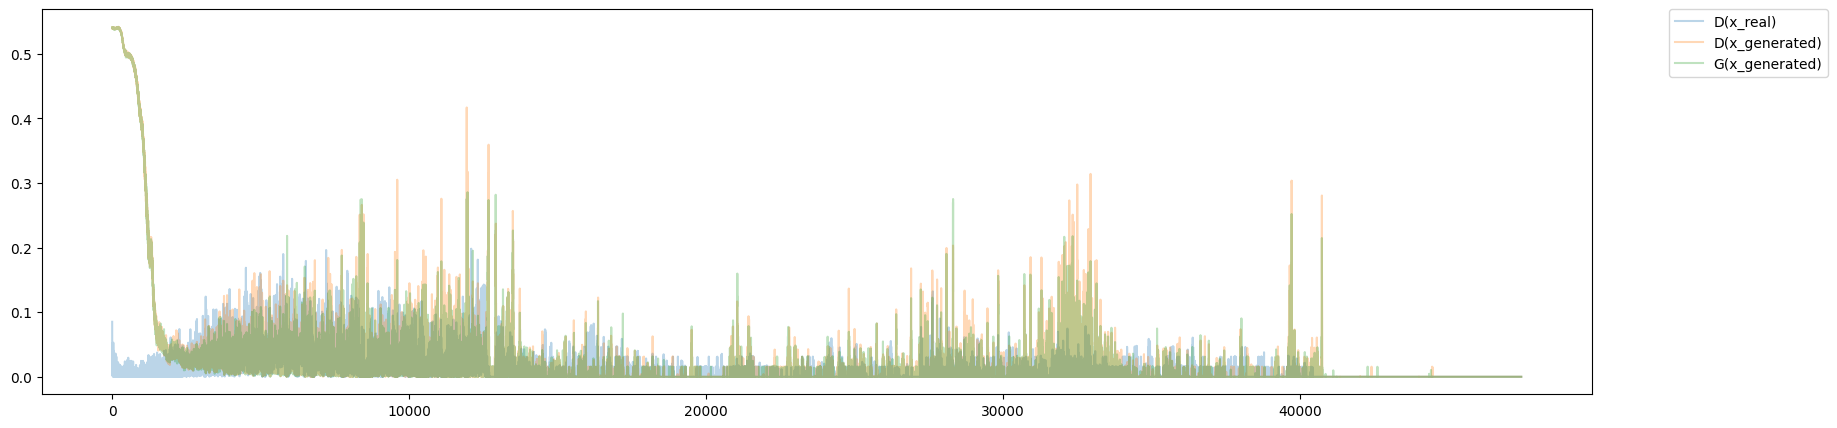

In [25]:
from matplotlib import pyplot as plt

sIdx = 50
plt.figure(figsize=(20,5))
plt.plot(p_d_real_trace[sIdx:], label='D(x_real)', alpha=0.3)
plt.plot(p_d_gen_trace[sIdx:], label='D(x_generated)', alpha=0.3)
plt.plot(p_g_gen_trace[sIdx:], label='G(x_generated)', alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

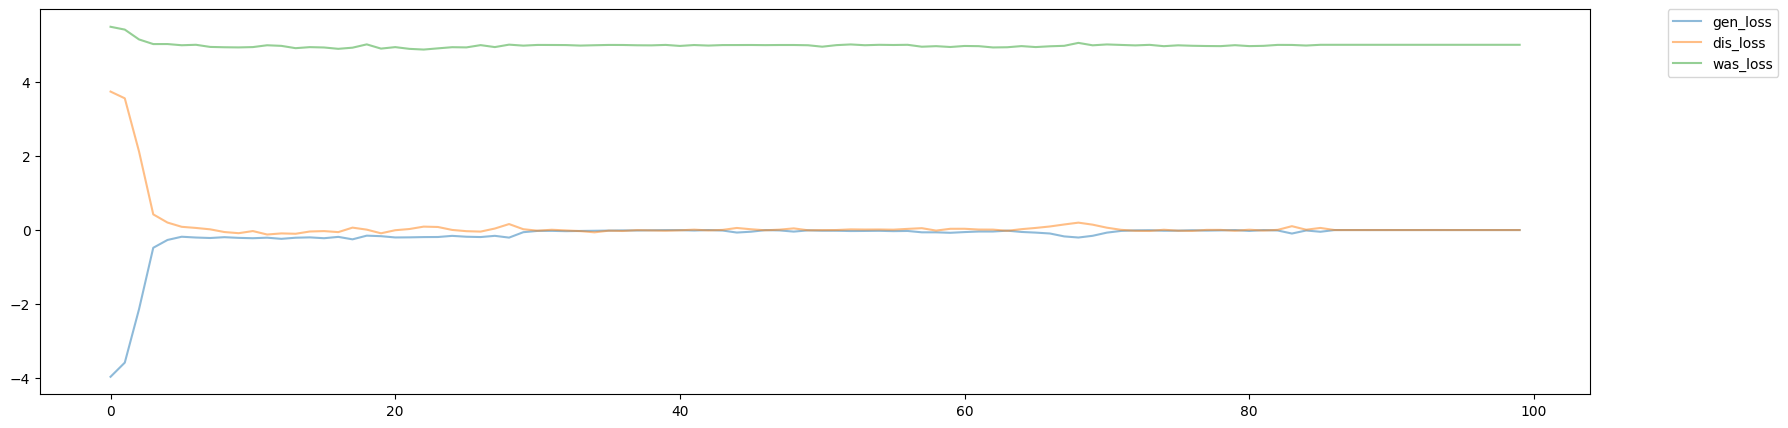

In [26]:
from matplotlib import pyplot as plt

sIdx = 0
plt.figure(figsize=(20,5))
plt.plot(gen_loss_trace[sIdx:], label='gen_loss', alpha=0.5)
plt.plot(dis_loss_trace[sIdx:], label='dis_loss', alpha=0.5)
plt.plot(was_loss_trace[sIdx:], label='was_loss', alpha=0.5)
# plt.ylim(0,2)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In [27]:
trg_label_ls = [1, 1, 1, 1]

check_df = data_df[(data_df[trg_yCols[0]+'_G']==trg_label_ls[0])|(data_df[trg_yCols[1]+'_G']==trg_label_ls[1])
                   |(data_df[trg_yCols[2]+'_G']==trg_label_ls[2])|(data_df[trg_yCols[3]+'_G']==trg_label_ls[3])]

n_samples = len(check_df)
gen_samples = check_condition(generator, n_samples, trg_label_ls, grNum_ls, latent_size).numpy()
gen_df = pd.DataFrame(gen_samples, columns=data_df.columns[:-len(trg_label_ls)])
# display('gen:',gen_df.describe(),'ori:',data_df[data_df[yCol+'_G']==trg_label].describe())
display('ori:',check_df.describe(),'gen:',gen_df.describe())

'ori:'

,RPM1,RPM2,RPM3,RPM4,RPM5,RPM6,RPM7,RPM8,RPM9,RPM10,RPM11,RPM12,RPM13,RPM14,RPM15,RPM16,RPM17,RPM18,RPM19,RPM20,RPM21,RPM22,RPM23,TEMP1,TEMP2,TEMP3,TEMP4,TEMP5,TEMP6,TEMP7,TEMP8,TEMP9,TEMP10,TEMP11,TEMP12,TEMP13,TEMP14,TEMP15,TEMP16,TEMP17,TEMP18,TEMP19,TEMP20,TEMP21,TEMP22,TEMP23,TIME1,TIME2,TIME3,TIME4,TIME5,TIME6,TIME7,TIME8,TIME9,TIME10,TIME11,TIME12,TIME13,TIME14,TIME15,TIME16,TIME17,TIME18,TIME19,TIME20,TIME21,TIME22,TIME23,JUK1,JUK2,JUK3,JUK4,JUK5,JUK6,JUK7,JUK8,JUK9,JUK10,JUK11,JUK12,JUK13,JUK14,JUK15,JUK16,JUK17,JUK18,JUK19,JUK20,JUK21,JUK22,JUK23,JRCODE1,JRCODE2,JRCODE3,JRCODE4,JRCODE5,JRCODE6,JRCODE7,JRCODE8,JRCODE9,JRCODE10,JRCODE11,JRCODE12,JRCODE13,JRCODE14,JRCODE15,JRCODE16,JRCODE17,JRCODE18,JRCODE19,JRCODE20,JRCODE21,JRCODE22,JRCODE23,JRCODE24,JRCODE25,PHR1,PHR2,PHR3,PHR4,PHR5,PHR6,PHR7,PHR8,PHR9,PHR10,PHR11,PHR12,PHR13,PHR14,PHR15,PHR16,PHR17,PHR18,PHR19,PHR20,PHR21,PHR22,PHR23,PHR24,PHR25,PUTGB1,PUTGB2,PUTGB3,PUTGB4,PUTGB5,PUTGB6,PUTGB7,PUTGB8,PUTGB9,PUTGB10,PUTGB11,PUTGB12,PUTGB13,PUTGB14,PUTGB15,PUTGB16,PUTGB17,PUTGB18,PUTGB19,PUTGB20,PUTGB21,PUTGB22,PUTGB23,PUTGB24,PUTGB25,HS_TEMP,HS_TIME,SG_TEMP,SG_TIME,TS_TEMP,TS_TIME,EB_TEMP,EB_TIME
count,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.00000,4113.000000,4113.000000,4113.00000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.0,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.0,4113.0,4113.0,4113.0,4113.0,4113.0,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.0,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.0,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.0,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000
mean,103.771721,107.639146,106.943734,108.114382,105.292538,105.848720,75.192280,74.792703,73.757416,89.603684,93.326976,144.884621,376.540530,542.581528,698.718940,786.986628,782.699003,785.468271,525.259908,276.110139,27.558473,6.416727,0.471918,79.062005,59.238189,59.607534,64.467305,82.840877,93.877866,111.845430,113.118593,112.352370,112.372566,100.448486,76.048335,54.747358,45.073487,34.722505,35.313395,37.013008,29.950644,13.043788,7.223049,1.141746,0.183613,0.019718,70.107681,21.282190,22.693641,26.868062,27.130076,17.444451,27.214425,22.263754,21.818428,22.175697,22.901724,18.218086,18.444299,11.27750,14.507604,16.694797,25.51984,15.975954,11.293095,4.802358,0.143010,0.008510,0.0,174.868760,43.185922,43.953544,56.692925,61.037941,39.905899,60.286239,54

'gen:'

,RPM1,RPM2,RPM3,RPM4,RPM5,RPM6,RPM7,RPM8,RPM9,RPM10,RPM11,RPM12,RPM13,RPM14,RPM15,RPM16,RPM17,RPM18,RPM19,RPM20,RPM21,RPM22,RPM23,TEMP1,TEMP2,TEMP3,TEMP4,TEMP5,TEMP6,TEMP7,TEMP8,TEMP9,TEMP10,TEMP11,TEMP12,TEMP13,TEMP14,TEMP15,TEMP16,TEMP17,TEMP18,TEMP19,TEMP20,TEMP21,TEMP22,TEMP23,TIME1,TIME2,TIME3,TIME4,TIME5,TIME6,TIME7,TIME8,TIME9,TIME10,TIME11,TIME12,TIME13,TIME14,TIME15,TIME16,TIME17,TIME18,TIME19,TIME20,TIME21,TIME22,TIME23,JUK1,JUK2,JUK3,JUK4,JUK5,JUK6,JUK7,JUK8,JUK9,JUK10,JUK11,JUK12,JUK13,JUK14,JUK15,JUK16,JUK17,JUK18,JUK19,JUK20,JUK21,JUK22,JUK23,JRCODE1,JRCODE2,JRCODE3,JRCODE4,JRCODE5,JRCODE6,JRCODE7,JRCODE8,JRCODE9,JRCODE10,JRCODE11,JRCODE12,JRCODE13,JRCODE14,JRCODE15,JRCODE16,JRCODE17,JRCODE18,JRCODE19,JRCODE20,JRCODE21,JRCODE22,JRCODE23,JRCODE24,JRCODE25,PHR1,PHR2,PHR3,PHR4,PHR5,PHR6,PHR7,PHR8,PHR9,PHR10,PHR11,PHR12,PHR13,PHR14,PHR15,PHR16,PHR17,PHR18,PHR19,PHR20,PHR21,PHR22,PHR23,PHR24,PHR25,PUTGB1,PUTGB2,PUTGB3,PUTGB4,PUTGB5,PUTGB6,PUTGB7,PUTGB8,PUTGB9,PUTGB10,PUTGB11,PUTGB12,PUTGB13,PUTGB14,PUTGB15,PUTGB16,PUTGB17,PUTGB18,PUTGB19,PUTGB20,PUTGB21,PUTGB22,PUTGB23,PUTGB24,PUTGB25,HS_TEMP,HS_TIME,SG_TEMP,SG_TIME,TS_TEMP,TS_TIME,EB_TEMP,EB_TIME
count,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000,4113.000000
mean,18.531368,-81.378136,293.224518,149.054886,64.876190,-7.106910,-13.004047,-31.574432,-6.623587,496.924744,241.523117,468.913696,799.802490,671.988464,832.048462,797.089478,760.894226,708.757690,519.251465,101.624863,18.406015,-0.349280,-24.584843,51.479057,94.602760,50.172958,91.175819,37.540489,9.908140,22.298878,-73.179085,-62.722080,-11.776272,-6.565701,107.143539,-1.922666,56.056400,-13.185179,75.573509,50.085560,-47.686172,7.710063,-17.253283,9.695921,-55.593128,-30.204550,89.380775,-36.327564,-22.774807,-2.021509,-33.472996,-24.761765,19.400906,14.858922,55.213139,64.919525,-43.284798,-22.390463,-55.056328,-13.257370,-65.549057,46.495510,25.104546,-22.524925,47.881828,-18.109529,0.183204,20.381931,-

In [ ]:
for trg_i in range(1, 4):
    trg_label = 4

    n_samples = len(check_df)
    gen_samples = check_condition(generator, n_samples, trg_label, condition_size, latent_size)
    gen_df = pd.DataFrame(gen_samples, columns=data_df.columns[:-1])
    # display('gen:',gen_df.describe(),'ori:',data_df[data_df[yCol+'_G']==trg_label].describe())
    display('ori:',check_df.iloc[:,:15].describe(),'gen:',gen_df.iloc[:,:15].describe())

In [182]:
batch_size = 64
lr = 0.005
num_epochs = 300
show_step = 25

stVal = 0

criterion = nn.BCELoss()

# 모델 인덱스
model_index = '1_1'

# 대상
yCols=['insp_pps_hs_val','insp_pps_sg_val','insp_pps_ts_val','insp_pps_eb_val']

for yCol in yCols[:1]:
    data_df = pd.read_csv(f'./dataset/data_{yCol}_jrcode_fin.csv')

    # 조건변수의 구간화
    nUniq = data_df[yCol].nunique()
    if nUniq < 100:
        grNum = nUniq//5
    else:
        grNum = nUniq//10
    print(f'groupNum : {grNum}')

    data_df[yCol+'_G'], cutBins = pd.qcut(data_df[yCol],grNum,labels=np.arange(stVal,stVal+grNum), retbins=True)
    # data_df[yCol+'_G'], cutBins = pd.cut(data_df[yCol],bins=grNum,labels=np.arange(stVal,stVal+grNum), retbins=True)

    # 원재료코드의 숫자로의 인코드
    for i in range(1, 21):
        data_df['jrcode'+str(i)] = data_df['jrcode'+str(i)].apply(lambda x: int(JRCODE_dict[x]))
        data_df['phr'+str(i)].fillna(0, inplace=True)

    # 분류의 숫자로의 인코드
    data_df['mix_ds_cd'] = data_df['mix_ds_cd'].apply(lambda x: int(MIXDSCD_dict[x]))

    # 필요없는 변수 제거
    data_df = data_df.drop(['lab_pk', yCol], axis=1)

    # batch_size 로 나눠지도록 나머지 버림
    data_df = data_df.iloc[:-(len(data_df) % batch_size)]

    # DataFrame을 PyTorch Tensor로 변환
    data = torch.tensor(data_df.values, dtype=torch.float32)

    # DataLoader 설정
    dataset = TensorDataset(data)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # 모델, 옵티마이저, 손실 함수 설정
    condition_size = grNum                                      # 조건 feature의 개수
    input_size = len(data_df.columns) - 1                       # 입력 feature의 개수
    output_size = input_size                                    # 출력 feature의 개수 (입력과 동일하게)
    latent_size = 100                                           # 잠재 공간의 크기
    
    discriminator = Discriminator(input_size, condition_size)
    generator = Generator(latent_size, output_size, condition_size)
    d_optimizer = optim.Adam(discriminator.parameters(), lr=lr)
    g_optimizer = optim.Adam(generator.parameters(), lr=lr)

    p_d_real_trace = []
    p_d_gen_trace = []
    p_g_gen_trace = []

    # 학습 시작
    stTime = time.time()
    for epoch in range(num_epochs):

        for n, (real_data,) in enumerate(dataloader):
            # batch_size = real_samples.size(0)

            real_data_labels = torch.ones((batch_size, 1))
            fake_data_labels = torch.zeros((batch_size, 1))

            x = real_data[:,:-1]
            labels = real_data[:,-1:]

            """
            FOR CONDITIONAL GAN
            """
            # Encode MNIST's label's with 'one hot encoding'
            label_encoded = F.one_hot(labels.to(torch.int64), num_classes=condition_size).squeeze(1)
            # concat real images with 'label encoded vector'
            real_data_concat = torch.cat((x, label_encoded), 1)

            # +---------------------+
            # |   train Generator   |
            # +---------------------+

            # Initialize grad
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()

            # make fake data with generator & noise vector 'z'
            z = torch.randn(batch_size, latent_size)

            """
            FOR CONDITIONAL GAN
            """
            # concat noise vector z with encoded labels
            z_concat = torch.cat((z, label_encoded), 1)
            fake_data = generator(z_concat)
            fake_data_concat = torch.cat((fake_data, label_encoded), 1)

            # Compare result of discriminator with fake images & real labels
            # If generator deceives discriminator, g_loss will decrease
            g_loss = criterion(discriminator(fake_data_concat), real_data_labels)

            # Train generator with backpropagation
            g_loss.backward()
            g_optimizer.step()

            # +---------------------+
            # | train Discriminator |
            # +---------------------+

            # Initialize grad
            d_optimizer.zero_grad()
            g_optimizer.zero_grad()

            # make fake images with generator & noise vector 'z'
            z = torch.randn(batch_size, latent_size)

            """
            FOR CONDITIONAL GAN
            """
            # concat noise vector z with encoded labels
            z_concat = torch.cat((z, label_encoded), 1)
            fake_data = generator(z_concat)
            fake_data_concat = torch.cat((fake_data, label_encoded), 1)

            # Calculate fake & real loss with generated images above & real images
            fake_loss = criterion(discriminator(fake_data_concat), fake_data_labels)
            real_loss = criterion(discriminator(real_data_concat), real_data_labels)
            d_loss = (fake_loss + real_loss) / 2

            # Train discriminator with backpropagation
            # In this part, we don't train generator
            d_loss.backward()
            d_optimizer.step()

            d_performance = discriminator(real_data_concat).mean()
            g_performance = discriminator(fake_data_concat).mean()

            p_d_real_trace.append(real_loss.item())
            p_d_gen_trace.append(fake_loss.item())
            p_g_gen_trace.append(g_loss.item())

            # Show loss
            if epoch % show_step == 0 and n == batch_size - 1:
                print(f"Epoch: {epoch:3.0f} Loss D.: {d_loss:.5f}, Loss G.: {g_loss:.5f}, time: {(time.time() - stTime):.3f}s")
                stTime = time.time()

groupNum : 14
Epoch:   0 Loss D.: 0.50051, Loss G.: 0.71363, time: 0.249s
Epoch:  25 Loss D.: 0.32031, Loss G.: 2.60511, time: 11.676s
Epoch:  50 Loss D.: 0.32761, Loss G.: 1.84174, time: 11.717s
Epoch:  75 Loss D.: 0.30266, Loss G.: 1.81060, time: 12.832s
Epoch: 100 Loss D.: 0.18928, Loss G.: 2.72459, time: 16.290s
Epoch: 125 Loss D.: 0.21401, Loss G.: 1.88179, time: 17.089s
Epoch: 150 Loss D.: 0.35820, Loss G.: 2.02565, time: 16.065s
Epoch: 175 Loss D.: 0.28396, Loss G.: 2.19446, time: 16.333s
Epoch: 200 Loss D.: 0.25761, Loss G.: 1.93010, time: 17.470s
Epoch: 225 Loss D.: 0.24665, Loss G.: 1.99608, time: 17.304s
Epoch: 250 Loss D.: 0.25050, Loss G.: 2.10930, time: 16.285s
Epoch: 275 Loss D.: 0.25123, Loss G.: 2.07746, time: 15.602s


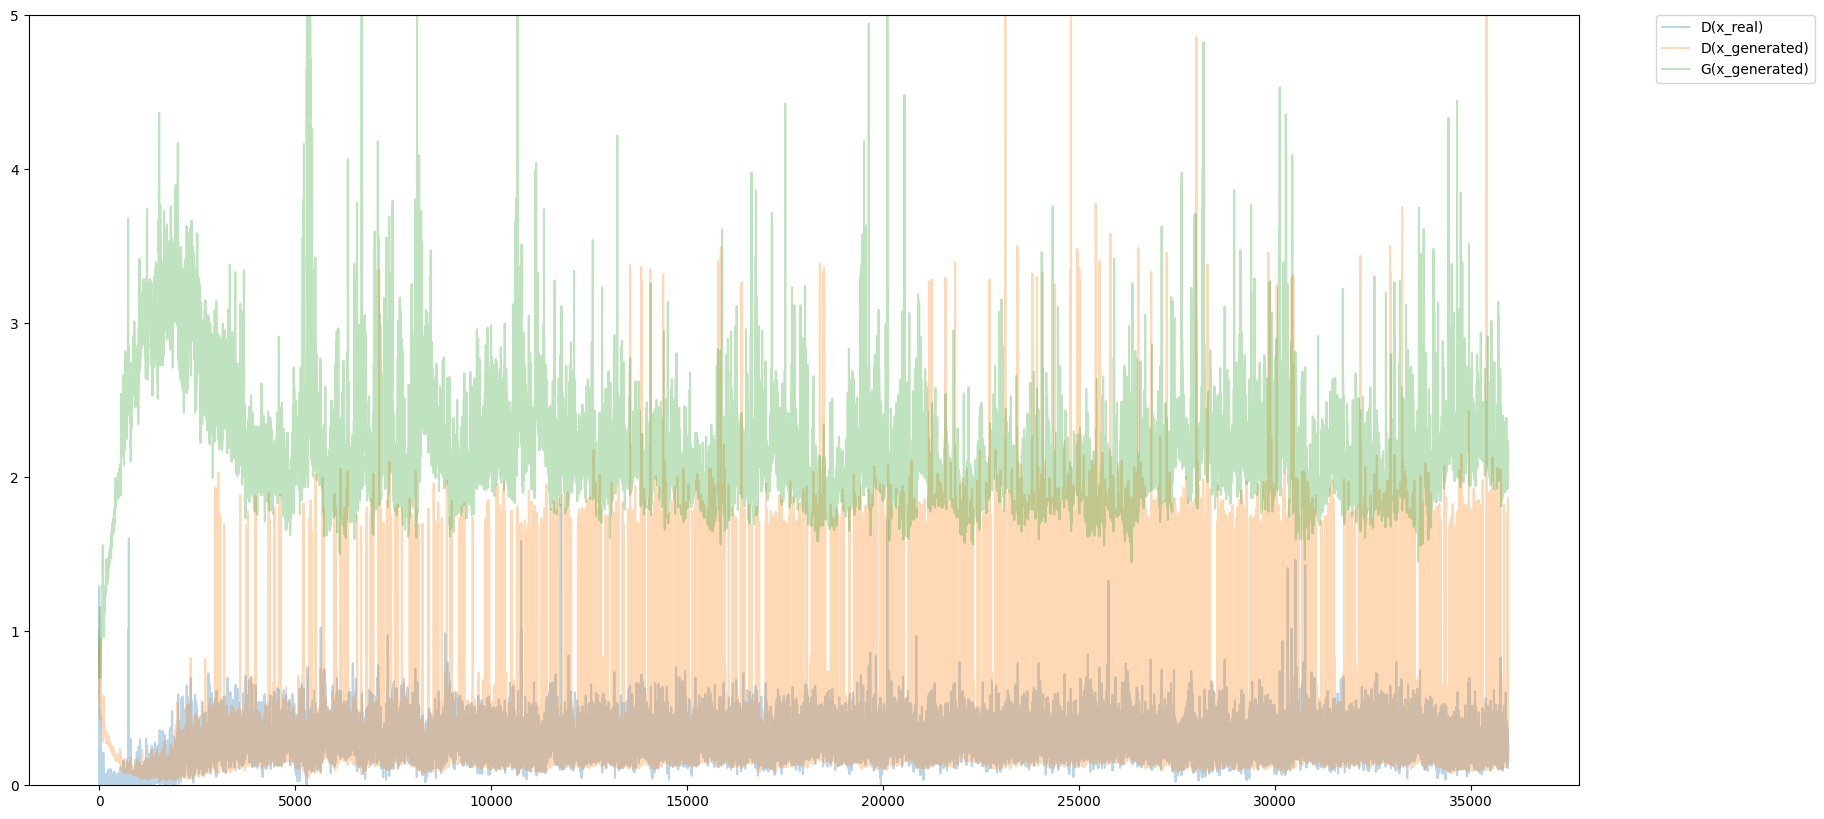

In [183]:
from matplotlib import pyplot as plt

sIdx = 50
plt.figure(figsize=(20,10))
plt.plot(p_d_real_trace[sIdx:], label='D(x_real)', alpha=0.3)
plt.plot(p_d_gen_trace[sIdx:], label='D(x_generated)', alpha=0.3)
plt.plot(p_g_gen_trace[sIdx:], label='G(x_generated)', alpha=0.3)
plt.ylim(0,5)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In [219]:
trg_label = 5
check_df = data_df[data_df[yCol+'_G']==trg_label]

n_samples = len(check_df)
gen_samples = check_condition(generator, n_samples, trg_label, condition_size, latent_size)
gen_df = pd.DataFrame(gen_samples, columns=data_df.columns[:-1])
# display('gen:',gen_df.describe(),'ori:',data_df[data_df[yCol+'_G']==trg_label].describe())
display('ori:',check_df.iloc[:,:15].describe(),'gen:',gen_df.iloc[:,:15].describe())

'ori:'

,mix_ds_cd,insp_pps_temp1_val,insp_pps_mnt1_val,jrcode1,phr1,jrcode2,phr2,jrcode3,phr3,jrcode4,phr4,jrcode5,phr5,jrcode6,phr6
count,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000
mean,2.960059,164.142012,10.207101,617.822485,58.066160,384.152367,21.505847,130.528107,3.629412,139.099112,2.211829,239.529586,3.790072,484.000000,12.308469
std,1.012457,5.484303,1.484241,114.398347,33.240787,287.624352,26.073398,206.450570,7.637641,180.814422,8.543604,299.592237,12.446505,482.376635,23.782983
min,1.000000,160.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,160.000000,10.000000,564.000000,28.425242,81.000000,2.932551,78.000000,0.666667,78.000000,0.488007,98.000000,0.492409,139.500000,0.558400
50%,2.000000,160.000000,10.000000,593.000000,50.588223,535.000000,9.852217,81.000000,1.500000,98.000000,0.923792,121.000000,1.000000,182.000000,1.500000
75%,4.000000,170.000000,10.000000,679.000000,100.000000,585.000000,29.186804,81.000000,4.242424,115.000000,1.500000,203.000000,1.818182,1158.000000,10.640481
max,4.000000,180.000000,20.000000,1257.000000,100.000000,1384.000000,100.000000,1397.000000,100.000000,1354.000000,100.000000,1336.000000,100.000000,1351.000000,100.000000


'gen:'

,mix_ds_cd,insp_pps_temp1_val,insp_pps_mnt1_val,jrcode1,phr1,jrcode2,phr2,jrcode3,phr3,jrcode4,phr4,jrcode5,phr5,jrcode6,phr6
count,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000
mean,5.239302,148.199753,-3.701936,586.186768,42.175926,470.517090,11.322204,233.751480,6.906368,149.191132,4.811017,135.154190,-5.002748,207.457108,3.695755
std,11.642853,124.348740,12.260484,414.110565,69.095535,349.727356,31.143972,251.125381,12.479310,88.564346,15.665997,105.214394,9.871914,171.358978,16.648355
min,-45.505825,-31.811869,-34.035484,44.828773,-114.353653,-266.818451,-96.101280,14.193126,-28.261034,-73.198082,-41.490665,-83.852142,-35.698647,-188.764725,-51.824936
25%,-1.220601,60.068775,-12.076432,322.183937,-7.622005,221.545635,-9.943029,113.519547,-0.716488,94.626415,-5.137944,65.058973,-11.348938,109.293476,-6.182551
50%,5.381783,118.955894,-3.730984,458.633682,29.614818,408.399078,10.898266,148.415504,4.977005,137.361786,3.966905,119.081120,-5.578967,174.171379,3.146662
75%,12.121728,202.598236,3.748100,733.303055,78.953356,661.135361,31.232914,218.961018,12.973989,190.008396,14.026663,187.743011,0.529417,264.465759,12.794605
max,44.851444,957.033020,39.025604,3511.902588,390.699799,2300.055420,109.714127,1713.023193,63.967693,629.136536,62.105064,650.368042,36.045055,1314.329102,64.564133


In [198]:
batch_size = 64
lr = 0.01
num_epochs = 300
show_step = 25

stVal = 0

criterion = nn.BCELoss()

# 모델 인덱스
model_index = '1_1'

# 대상
yCols=['insp_pps_hs_val','insp_pps_sg_val','insp_pps_ts_val','insp_pps_eb_val']

for yCol in yCols[1:2]:
    data_df = pd.read_csv(f'./dataset/data_{yCol}_jrcode_fin.csv')

    # 조건변수의 구간화
    nUniq = data_df[yCol].nunique()
    if nUniq < 100:
        grNum = nUniq//5
    else:
        grNum = nUniq//10
    print(f'groupNum : {grNum}')

    data_df[yCol+'_G'], cutBins = pd.qcut(data_df[yCol],grNum,labels=np.arange(stVal,stVal+grNum), retbins=True)
    # data_df[yCol+'_G'], cutBins = pd.cut(data_df[yCol],bins=grNum,labels=np.arange(stVal,stVal+grNum), retbins=True)

    # 원재료코드의 숫자로의 인코드
    for i in range(1, 21):
        data_df['jrcode'+str(i)] = data_df['jrcode'+str(i)].apply(lambda x: int(JRCODE_dict[x]))
        data_df['phr'+str(i)].fillna(0, inplace=True)

    # 분류의 숫자로의 인코드
    data_df['mix_ds_cd'] = data_df['mix_ds_cd'].apply(lambda x: int(MIXDSCD_dict[x]))

    # 필요없는 변수 제거
    data_df = data_df.drop(['lab_pk', yCol], axis=1)

    # batch_size 로 나눠지도록 나머지 버림
    data_df = data_df.iloc[:-(len(data_df) % batch_size)]

    # DataFrame을 PyTorch Tensor로 변환
    data = torch.tensor(data_df.values, dtype=torch.float32)

    # DataLoader 설정
    dataset = TensorDataset(data)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # 모델, 옵티마이저, 손실 함수 설정
    condition_size = grNum                                      # 조건 feature의 개수
    input_size = len(data_df.columns) - 1                       # 입력 feature의 개수
    output_size = input_size                                    # 출력 feature의 개수 (입력과 동일하게)
    latent_size = 100                                           # 잠재 공간의 크기
    
    discriminator = Discriminator(input_size, condition_size)
    generator = Generator(latent_size, output_size, condition_size)
    d_optimizer = optim.Adam(discriminator.parameters(), lr=lr)
    g_optimizer = optim.Adam(generator.parameters(), lr=lr)

    p_d_real_trace = []
    p_d_gen_trace = []
    p_g_gen_trace = []

    # 학습 시작
    stTime = time.time()
    for epoch in range(num_epochs):

        for n, (real_data,) in enumerate(dataloader):
            # batch_size = real_samples.size(0)

            real_data_labels = torch.ones((batch_size, 1))
            fake_data_labels = torch.zeros((batch_size, 1))

            x = real_data[:,:-1]
            labels = real_data[:,-1:]

            """
            FOR CONDITIONAL GAN
            """
            # Encode MNIST's label's with 'one hot encoding'
            label_encoded = F.one_hot(labels.to(torch.int64), num_classes=condition_size).squeeze(1)
            # concat real images with 'label encoded vector'
            real_data_concat = torch.cat((x, label_encoded), 1)

            # +---------------------+
            # |   train Generator   |
            # +---------------------+

            # Initialize grad
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()

            # make fake data with generator & noise vector 'z'
            z = torch.randn(batch_size, latent_size)

            """
            FOR CONDITIONAL GAN
            """
            # concat noise vector z with encoded labels
            z_concat = torch.cat((z, label_encoded), 1)
            fake_data = generator(z_concat)
            fake_data_concat = torch.cat((fake_data, label_encoded), 1)

            # Compare result of discriminator with fake images & real labels
            # If generator deceives discriminator, g_loss will decrease
            g_loss = criterion(discriminator(fake_data_concat), real_data_labels)

            # Train generator with backpropagation
            g_loss.backward()
            g_optimizer.step()

            # +---------------------+
            # | train Discriminator |
            # +---------------------+

            # Initialize grad
            d_optimizer.zero_grad()
            g_optimizer.zero_grad()

            # make fake images with generator & noise vector 'z'
            z = torch.randn(batch_size, latent_size)

            """
            FOR CONDITIONAL GAN
            """
            # concat noise vector z with encoded labels
            z_concat = torch.cat((z, label_encoded), 1)
            fake_data = generator(z_concat)
            fake_data_concat = torch.cat((fake_data, label_encoded), 1)

            # Calculate fake & real loss with generated images above & real images
            fake_loss = criterion(discriminator(fake_data_concat), fake_data_labels)
            real_loss = criterion(discriminator(real_data_concat), real_data_labels)
            d_loss = (fake_loss + real_loss) / 2

            # Train discriminator with backpropagation
            # In this part, we don't train generator
            d_loss.backward()
            d_optimizer.step()

            d_performance = discriminator(real_data_concat).mean()
            g_performance = discriminator(fake_data_concat).mean()

            p_d_real_trace.append(real_loss.item())
            p_d_gen_trace.append(fake_loss.item())
            p_g_gen_trace.append(g_loss.item())

            # Show loss
            if epoch % show_step == 0 and n == batch_size - 1:
                print(f"Epoch: {epoch:3.0f} Loss D.: {d_loss:.5f}, Loss G.: {g_loss:.5f}, time: {(time.time() - stTime):.3f}s")
                stTime = time.time()

groupNum : 55
Epoch:   0 Loss D.: 0.45753, Loss G.: 1.08188, time: 0.241s
Epoch:  25 Loss D.: 0.33380, Loss G.: 1.71180, time: 12.160s
Epoch:  50 Loss D.: 0.49588, Loss G.: 1.16298, time: 12.255s
Epoch:  75 Loss D.: 1.19239, Loss G.: 1.06157, time: 12.839s
Epoch: 100 Loss D.: 0.55447, Loss G.: 0.96982, time: 15.712s
Epoch: 125 Loss D.: 0.63722, Loss G.: 0.82721, time: 16.892s
Epoch: 150 Loss D.: 1.38737, Loss G.: 0.81494, time: 16.095s
Epoch: 175 Loss D.: 2.18269, Loss G.: 0.78509, time: 16.582s
Epoch: 200 Loss D.: 0.67664, Loss G.: 0.71070, time: 17.271s
Epoch: 225 Loss D.: 0.67668, Loss G.: 0.72877, time: 16.931s
Epoch: 250 Loss D.: 2.23939, Loss G.: 0.67013, time: 16.090s
Epoch: 275 Loss D.: 0.69315, Loss G.: 0.69645, time: 16.423s


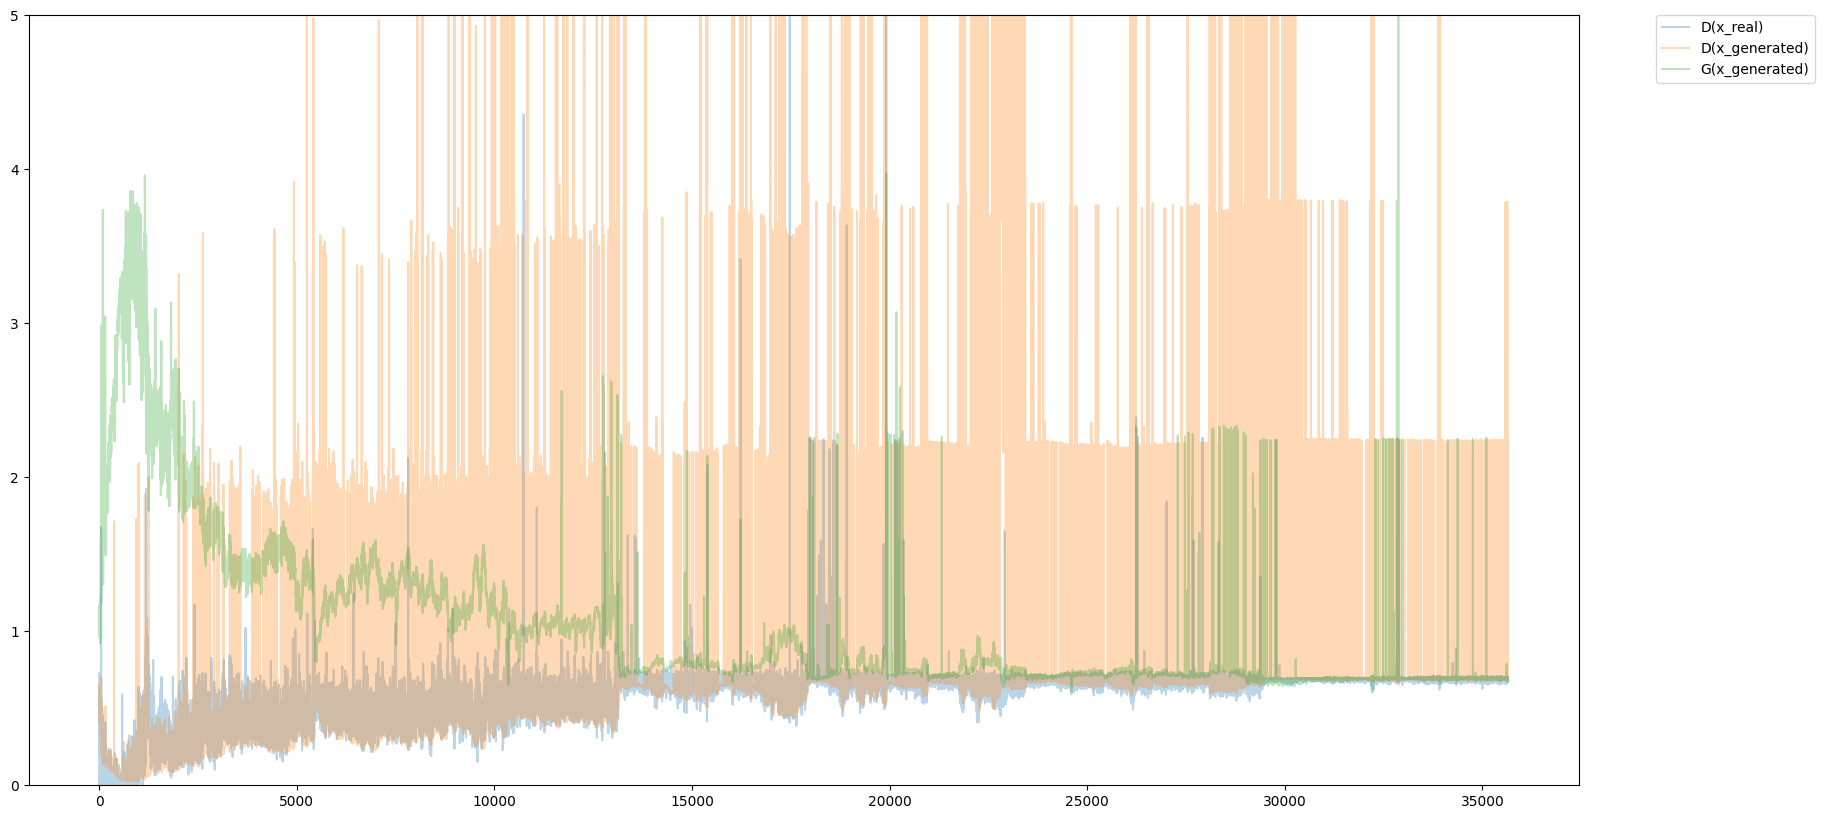

In [199]:
from matplotlib import pyplot as plt

sIdx = 50
plt.figure(figsize=(20,10))
plt.plot(p_d_real_trace[sIdx:], label='D(x_real)', alpha=0.3)
plt.plot(p_d_gen_trace[sIdx:], label='D(x_generated)', alpha=0.3)
plt.plot(p_g_gen_trace[sIdx:], label='G(x_generated)', alpha=0.3)
plt.ylim(0,5)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In [215]:
trg_label = 10
check_df = data_df[data_df[yCol+'_G']==trg_label]

n_samples = len(check_df)
gen_samples = check_condition(generator, n_samples, trg_label, condition_size, latent_size)
gen_df = pd.DataFrame(gen_samples, columns=data_df.columns[:-1])
# display('gen:',gen_df.describe(),'ori:',data_df[data_df[yCol+'_G']==trg_label].describe())
display('ori:',check_df.iloc[:,:15].describe(),'gen:',gen_df.iloc[:,:15].describe())

'ori:'

,mix_ds_cd,insp_pps_temp1_val,insp_pps_mnt1_val,jrcode1,phr1,jrcode2,phr2,jrcode3,phr3,jrcode4,phr4,jrcode5,phr5,jrcode6,phr6
count,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000
mean,2.980132,164.172185,10.099338,600.456954,56.325473,408.000000,26.501467,96.642384,3.037828,100.781457,1.092166,141.814570,1.965411,426.920530,11.029871
std,1.003130,6.669094,1.757858,119.539602,32.509125,245.979701,28.967898,75.348023,3.145778,44.433305,1.441650,135.650109,8.742875,487.804203,24.838647
min,2.000000,160.000000,5.000000,0.000000,0.000000,78.000000,0.499426,78.000000,0.149477,78.000000,0.071073,78.000000,0.071073,78.000000,0.071073
25%,2.000000,160.000000,10.000000,566.500000,29.640601,81.000000,4.000000,78.000000,0.683333,78.000000,0.378310,98.000000,0.492134,115.000000,0.630517
50%,2.000000,160.000000,10.000000,581.000000,50.397878,556.000000,15.915119,81.000000,1.795332,98.000000,0.763359,121.000000,0.819672,142.000000,1.146132
75%,4.000000,170.000000,10.000000,675.000000,99.504950,566.000000,35.502834,81.000000,4.310345,98.000000,1.237113,142.000000,1.333333,419.000000,2.857143
max,4.000000,180.000000,15.000000,740.000000,100.000000,756.000000,100.000000,734.000000,16.666667,419.000000,11.666667,1265.000000,100.000000,1382.000000,100.000000


'gen:'

,mix_ds_cd,insp_pps_temp1_val,insp_pps_mnt1_val,jrcode1,phr1,jrcode2,phr2,jrcode3,phr3,jrcode4,phr4,jrcode5,phr5,jrcode6,phr6
count,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000
mean,-34.808735,127.001602,13.723177,448.253723,-9.561215,377.140198,-100.883659,148.846985,-20.628820,224.602341,13.946338,172.143600,17.661026,370.638306,46.064182
std,75.199966,119.674240,76.913132,264.148926,85.123444,328.127869,124.514351,169.375336,85.620636,247.624054,53.027748,220.230408,60.700634,281.962372,77.928253
min,-198.798340,-218.556061,-222.746201,-102.523758,-255.128830,-675.010315,-417.139069,-356.007324,-255.023361,-244.805527,-116.011909,-351.672180,-109.508469,-308.734833,-159.044312
25%,-90.089817,47.632133,-38.245058,271.852371,-71.955517,136.704262,-186.158157,33.534189,-79.194080,41.345959,-17.811939,19.386740,-19.996049,168.294029,-0.596966
50%,-41.180214,132.871124,16.591257,408.264557,-12.848492,346.785553,-107.537399,143.448456,-5.552504,222.416504,11.430079,156.297623,9.328079,338.590942,45.898983
75%,17.522262,206.631485,71.221115,613.869019,55.507427,573.089813,-28.525495,251.666046,38.751699,369.884842,46.821920,310.164352,49.880684,572.837128,94.088707
max,151.234192,433.670959,223.022049,1225.015259,212.509659,1130.341309,230.204010,594.480652,206.418289,929.869812,206.294464,1002.719482,247.057678,1103.091797,312.312592
